# Generative Adversarial Networks

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_palette('GnBu_d')
sns.set_style('whitegrid')

## Data Loading

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('Data/', one_hot=True)

Extracting Data/train-images-idx3-ubyte.gz
Extracting Data/train-labels-idx1-ubyte.gz
Extracting Data/t10k-images-idx3-ubyte.gz
Extracting Data/t10k-labels-idx1-ubyte.gz


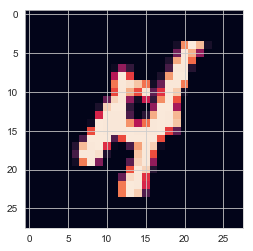

In [4]:
plt.imshow(mnist.train.images[777].reshape(28,28));

## Defining Placeholders

In [5]:
tf.reset_default_graph()

with tf.name_scope('inputs'):
    real_images = tf.placeholder(tf.float32, shape=[None,784])
    z = tf.placeholder(tf.float32, shape=[None,100])

## Creating Generator

In [6]:
def generator(z, reuse=None):
    with tf.variable_scope('gen', reuse=reuse):
        alpha = 0.01
        hidden1 = tf.layers.dense(inputs=z, units=128)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha * hidden2, hidden2)
        output = tf.layers.dense(hidden2, units=784, activation=tf.nn.tanh)
        return output

In [7]:
G = generator(z)

## Creating Discriminator

In [8]:
def discriminator(X, reuse=None):
    with tf.variable_scope('dis', reuse=reuse):
        alpha = 0.01
        hidden1 = tf.layers.dense(inputs=X, units=128)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha * hidden2, hidden2)
        logits = tf.layers.dense(hidden2, units=1)
        output = tf.sigmoid(logits)
        return output, logits

In [9]:
D_output_real, D_logits_real = discriminator(real_images)
D_output_fake, D_logits_fake = discriminator(G, reuse=True)

## Defining Loss Function

In [10]:
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))

In [11]:
with tf.name_scope('loss'):
    D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real) * (0.9))
    D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))
    D_loss = D_real_loss + D_fake_loss
    G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

## Training Model

In [12]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [13]:
learning_rate = 0.001

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    D_trainer = optimizer.minimize(D_loss, var_list=d_vars)
    G_trainer = optimizer.minimize(G_loss, var_list=g_vars)

## Running Model

In [14]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [20]:
n_epochs = 100
batch_size = 150
samples = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            batch = mnist.train.next_batch(batch_size)
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 - 1
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            sess.run(G_trainer, feed_dict={z: batch_z})
        print("Currently on Epoch {} of {} total...".format(epoch + 1, n_epochs))
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z, reuse=True), feed_dict={z: sample_z})
        samples.append(gen_sample)
        
    save_path = saver.save(sess, './Models/tf_gan_example.ckpt')

Currently on Epoch 1 of 100 total...
Currently on Epoch 2 of 100 total...
Currently on Epoch 3 of 100 total...
Currently on Epoch 4 of 100 total...
Currently on Epoch 5 of 100 total...
Currently on Epoch 6 of 100 total...
Currently on Epoch 7 of 100 total...
Currently on Epoch 8 of 100 total...
Currently on Epoch 9 of 100 total...
Currently on Epoch 10 of 100 total...
Currently on Epoch 11 of 100 total...
Currently on Epoch 12 of 100 total...
Currently on Epoch 13 of 100 total...
Currently on Epoch 14 of 100 total...
Currently on Epoch 15 of 100 total...
Currently on Epoch 16 of 100 total...
Currently on Epoch 17 of 100 total...
Currently on Epoch 18 of 100 total...
Currently on Epoch 19 of 100 total...
Currently on Epoch 20 of 100 total...
Currently on Epoch 21 of 100 total...
Currently on Epoch 22 of 100 total...
Currently on Epoch 23 of 100 total...
Currently on Epoch 24 of 100 total...
Currently on Epoch 25 of 100 total...
Currently on Epoch 26 of 100 total...
Currently on Epoch 27

## Predicting Data

In [21]:
saver = tf.train.Saver(var_list=g_vars)
new_samples = []

with tf.Session() as sess:
    saver.restore(sess, save_path)
    for x in range(5):
        sample_z = np.random.uniform(-1, 1, size=(1,100))
        gen_sample = sess.run(generator(z, reuse=True), feed_dict={z:sample_z})
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from ./Models/tf_gan_example.ckpt


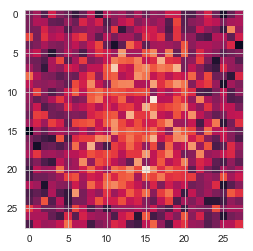

In [22]:
plt.imshow(samples[0].reshape(28, 28));